# Clasificación de entidades nombradas con una RNN 🧠
La idea es entrenar una RNN para clasificar entidades nombradas en categorías (**PERSON**, **LOCATION**, **ORGANIZATION**, **OTHER**)
y otra RNN para clasificarlas en tópicos.

Por ahora vamos a clasificar por categorías para testear qué tan bien anda esta arquitectura con los datos que tenemos (pocos!).

Pensando en el proyecto en sí, usaríamos este modelo para categorizar las entidades nombradas si es que no se encuentran en el diccionario (en vez de asignarles la categoría "comodín": **OTHER**)

Para crear y entrenar la RNN nos basamos en un tutorial de [Patrick Loeber](https://www.youtube.com/watch?v=WEV61GmmPrk), a su vez basado en este blog de [pytorch.org](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

Para generar los datos, llenamos algunos a mano para cada categoría al resto los generamos con GPT 3.5 (ChatGPT free) y los revisamos manualmente.

## Pasos
- Armar dataset de categorías **PERSON**, **LOCATION**, **ORGANIZATION**, **OTHER** usando ChatGPT
- Cargar el dataset en este Colab
- Normalizar dataset
- (....)
- Modelo decente



## Importante ❗
El código se conecta a Google Drive y busca la carpeta `My Drive/nn-category-classification/training-data`, donde debe haber un archivo para cada categoría (person, location, organization) conteniendo los datos de entrenamiento.

Pueden obtener los mismos datos que estoy usando. Para eso, copiar [esta carpeta](https://drive.google.com/drive/folders/1N4FA62g0iQAnIEg0I84xHip02sX10lGx?usp=sharing) a tu carpeta prinicipal de Google Drive.

In [1]:
from google.colab import drive
import os
import io
import glob
import unicodedata
import string
drive.mount('/content/drive/')

base_file_path = "/content/drive/My Drive/nn-category-classification/"

def findFiles(path): return glob.glob(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).



Todos los datos fueron generados usando GPT 3.5 🤯

Por ende, el dataset no está limpio. El primer paso es procesarlos y eliminar entries duplicadas.

In [2]:
# A partir de raw data para cada categoría (persona.txt, organizacion.txt, ...)
# Eliminar repetidos y normalizar las entries.

datasets = findFiles(base_file_path+'training-data/*.txt')

ALL_LETTERS = string.ascii_letters + ".,; "
N_LETTERS = len(ALL_LETTERS)

def normalize(entry):
  return ''.join(
      c for c in unicodedata.normalize('NFD', entry)
      if unicodedata.category(c) != 'Mn'
      and c in ALL_LETTERS
  )

def process_lines(filename):
    # Normalizar los entries del dataset
    n=0
    lines_clean = []
    lines = io.open(filename,  encoding="utf-8").read().split('\n')
    for line in lines:
        line = normalize(line)
        if line not in lines_clean:
          lines_clean.append(line)
        n += 1

    # print(len(lines_clean), n)
    return lines_clean, n

In [3]:
# Utils, preprocesar data

def load_data():
  category_lines = {}
  all_categories = []

  for filename in datasets:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)

    lines, n = process_lines(filename)
    category_lines[category] = lines

  return category_lines, all_categories

In [4]:
# Probamos el dataset...

category_lines, all_categories = load_data()
print(category_lines["person"][:5])

['Diego Maradona', 'Lionel Messi', 'Che Guevara', 'Eva Peron', 'Jorge Luis Borges']


Ya tenemos el dataset listo. Ahora pasamos a definir tensores y partes específicas de la RNN previo a la definición del modelo en sí.

Vamos a hacer un modelo de predicción por caracteres, y usamos one-hot encoding para representar letras y palabras numéricamente en tensores.

In [5]:
import torch
import random

"""
Para representar una sola letra usamos un "one-hot vector"
de tamaño <1 x n_letras>.

Para representar una palabra, metemos muchos de esos vectores
en una matriz 2D <largo_linea x 1 x n_letras>, donde 1 es el batch size
"""

# Encontrar letter index en all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Convertir letra en tensor <1 x n_letters>
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Convertir linea en <line_length x 1 x n_letters>,
# un array de one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# Obtener sample random para entrenar el modelo
def random_training_sample(category_lines, all_categories):

    def random_choice(a):
        random_index = random.randint(0, len(a) - 1)
        return a[random_index]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

print(letter_to_tensor("a"))
print(line_to_tensor("Juan").size())



tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([4, 1, 56])


Ahora sí, el modelo en sí 🤓

![Una RNN vanilla en Pytorch](images/pytorch-vanilla-rnn.png)

TODO: investigar `torch.nn.Linear()`, softmax


In [6]:
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden layer
        self.i20 = nn.Linear(input_size + hidden_size, output_size) # input to output layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        """
        Se entiende mejor viendo el gráfico de RNN!
        """
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i20(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
      return torch.zeros(1, self.hidden_size)


Teniendo la estructura de la RNN lista podemos instanciar un modelo y hacer un paso de entrenamiento manualmente!


In [7]:
# category_lines, all_categories = load_data()

n_categories = len(all_categories)

# Instanciamos modelo nuevo con 128 hidden layers
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# Un paso de entrenamiento manual!
input_tensor = letter_to_tensor("a")
hidden_tensor = rnn.init_hidden()

# Hacemos un forward pass e imprimimos el resultado
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 3])
torch.Size([1, 128])


Ahora sí, el entrenamiento.

person
0 0.0% 1.1304 San Salvador | organization WRONG | location
5000 10.0% 1.0985 World Intellectual Property Organization | location WRONG | organization
10000 20.0% 1.1279 Joan Manuel Serrat | location WRONG | person
15000 30.0% 0.7376 CARE Chile | organization CORRECT
20000 40.0% 1.4435 Grand Junction | organization WRONG | location
25000 50.0% 0.2150 Nogales | location CORRECT
30000 60.0% 2.5473 Santo Domingo | person WRONG | location
35000 70.0% 0.2600 Michael Jordan | person CORRECT
40000 80.0% 0.0369 Transparency International Mexico | organization CORRECT
45000 90.0% 0.0000 Camara de Representantes de Uruguay | organization CORRECT


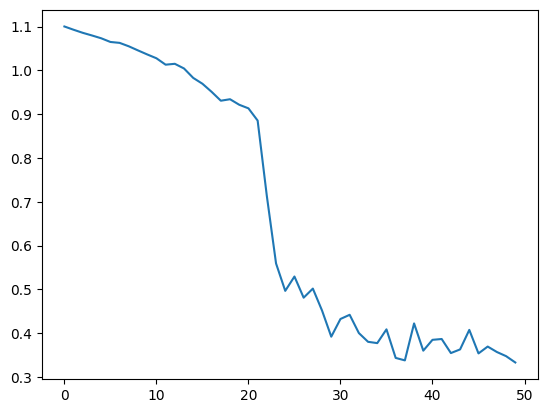

In [8]:
# Devolver la categoría con maxima probabilidad
def category_from_output(output):
    category_index = torch.argmax(output).item()
    #if (-0.2 <= torch.argmax(output) and torch.argmax(output) <= 0.2):
      #return "other"
    return all_categories[category_index]

print(category_from_output(output))

criterion = nn.NLLLoss() # negative log-likelihood
learning_rate = 0.001
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)  # stoch grad desc

# Un training step
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 50000

# Entrenamiento!
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_sample(category_lines, all_categories)

    while category == "" or line == "" or torch.isnan(category_tensor):
      category, line, category_tensor, line_tensor = random_training_sample(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if i % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG | {category}"
        print(f"{i} {(i/n_iters*100):.1f}% {loss:.4f} {line} | {guess} {correct}")

# Plotteamos el loss
plt.figure()
plt.plot(all_losses)
plt.show()

#### Ya podemos probar el modelo 🎉

In [10]:
# Inferencia!
def predict(input_line):
  with torch.no_grad():
      line_tensor = line_to_tensor(input_line)

      hidden = rnn.init_hidden()

      for i in range(line_tensor.size()[0]):
          output, hidden = rnn(line_tensor[i], hidden)

      return category_from_output(output)

while True:
  input_line = input()
  if input_line == "quit":
    break

  prediction = predict(input_line)

  if prediction:
    print(predict(input_line) + "\n")

Jorge Pérez
person

Comisión Nacional de Actividades Espaciales
organization

Cuba
location

quit


Y vamos que funciona bien con inputs no presentes en el dataset 🤙

De todas fomas, el _loss_ no es ideal (>0.3).  

Falta probar distintos hiperparámetros (acá una [cheatsheet interesante](https://gist.github.com/DavidIsrawi/6c45744c12a4f8fc08bd5b8f7f9e06d8)), pero **sobre todo** *conseguir* mejores datos. En este momento el modelo no es buenos distinguiendo nombres (Fernandez, Milei, Alvarez) de lugares. Tempoco categoriza clubes de futbol como organizaciones, por ejemplo.

### Ahora guardamos el modelo 💾

Usamos el método `torch.save()`, que guarda los parámetros del modelo (su `state_dict`).

A partir de este archivo podemos cargar el modelo.


In [17]:
# Guardamos el modelo en el archivo "model.pth"
torch.save(rnn.state_dict(), base_file_path + "/model.pth")

# Cargamos el modelo desde el archivo que guardamos
rnn_2 = RNN(N_LETTERS, n_hidden, n_categories)
rnn_2.load_state_dict(torch.load(base_file_path + "/model.pth"))
rnn_2.eval()


RNN(
  (i2h): Linear(in_features=184, out_features=128, bias=True)
  (i20): Linear(in_features=184, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)